# My solution to the Speech Emotion Reconition task
This notebook contains all the code used to analyze the dataset, train the models and compute their performance.

In [ ]:
# Google drive connection and import of all the needed libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import tqdm
import time
import librosa
import soundfile
import statistics
import numpy as np
import pandas as pd
import random as rn
import librosa.display
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score

os.environ["PYTHONHASHSEED"]="0"  # necessary for reproducible results of certain Python hash-based operations.

rn.seed(14)                       # necessary for starting core Python generated random numbers in a well-defined state.

np.random.seed(42)                # necessary for starting Numpy generated random numbers in a well-defined initial state.   

tf.random.set_seed(42)            # necessary to random number generation in TensorFlow have a well-defined initial state.

In [ ]:
# Global variable definition
BASE_DIR = "/content/drive/MyDrive/LoopQPrize/"  # I have stored everything on my Google Drive
MODEL_DIR = BASE_DIR + "models/"
DATA_DIR = BASE_DIR + "dataset/"
FEATURES_DIR = DATA_DIR + "features/"
TRAIN_DIR = DATA_DIR + "train/"
TEST_DIR = DATA_DIR + "test/"

TRAINING_FILE = DATA_DIR + "2022challengeA_train.csv"
VALIDATION_FILE = DATA_DIR + "2022challengeA_val.csv"
TEST_FILE = DATA_DIR + "2022challengeA_test.csv"

TARGET_COLUMN = "emotion"
NUM_CLASSES = 7
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sadness', 'surprise']

# Dictionaries that maps class code to class name and vice versa
id2label = {str(i): label for i, label in enumerate(CLASS_NAMES)}
label2id = {v: k for k, v in id2label.items()}

# Utilities

In [ ]:
def get_train_val_annot():
  '''Returns the pandas dataframes with the training and the validation set'''
  if not os.path.exists(VALIDATION_FILE):
    train_set = pd.read_csv(TRAINING_FILE, index_col=0)
    train_set.dropna(inplace=True)  #element with index 8937 has emotion = NaN

    #split the training dataset into train, validation set respectively with the 80% and 20% of the original samples 
    train_annot, val_annot = train_test_split(train_set, test_size=0.2, random_state=42, shuffle=True, stratify=train_set[TARGET_COLUMN])
    val_annot.to_csv(VALIDATION_FILE)
  else:
    train_annot = pd.read_csv(TRAINING_FILE, index_col=0)
    val_annot = pd.read_csv(VALIDATION_FILE, index_col=0)
  
  return train_annot, val_annot


def get_features_labels(name, feature_type, feature_subtype):
  '''Returns the features and the labels of the type and from the dataset specified.
    Parameters
    ----------
    name: name of the dataset you need, Possibilities are "train" and "val".

    feature_type: type of feature you need, Possibilities are "1" for 1D-feature and "2" for 2D-features.

    feature_subtype: is used only when feature_type is "1". Possibilities are "" for all the features, _no_mel" just for chroma and mfcc, "_no_mel_no_chroma" just form mfcc.
    
    Return
    ----------
    features: numpy.ndarray with the features needed.
    labels: numpy.ndarray with the ground thruth.
  '''
  if feature_type == "1": 
    feature_file = FEATURES_DIR + name + "_" + feature_type + feature_subtype + ".npy" 
  else:
    feature_file = FEATURES_DIR + name + "_" + feature_type + ".npy" 
   
  with open(feature_file, 'rb') as f:
    features = np.load(f)
    labels = np.load(f)

  if feature_type == "2":
    features = features.reshape(-1, 128, 251, 1)  

  return features, labels


def get_dataset_fused_model(name, feature_subtype="", scaled=True):
  '''Returns the 1D and 2D features needed for the cnn1D-lstm and cnn2D-lstm fused model.
    Parameters
    ----------
    name: name of the dataset you need, Possibilities are "train" and "val".

    feature_subtype: is used to specify the type of 1D features. Possibilities are "" for all the features, _no_mel" just for chroma and mfcc, "_no_mel_no_chroma" just form mfcc.
    
    scaled: use a standard scaler to scale the features.
    Return
    ----------
    features1D: numpy.ndarray with the 1D features needed.
    features2D: numpy.ndarray with the 2D features needed.
    labels: numpy.ndarray with the ground thruth.
  ''' 
  features_1D, labels = get_features_labels(name, "1", feature_subtype)
  features_2D, _ = get_features_labels(name, "2",feature_subtype)

  if scaled:
    features_1D = scale_features(features_1D)
    features_2D = scale_features(features_2D)

  return features_1D, features_2D, labels


def get_dataset(name, feature_type, feature_subtype="", batch_size=32, scaled=True):
  '''Returns a tensorflow dataset composed with the features and from the dataset specified.
    Parameters
    ----------
    name: name of the dataset you need, Possibilities are "train" and "val".
    
    feature_type: type of feature you need, Possibilities are "1" for 1D-feature and "2" for 2D-features.

    feature_subtype: is used to specify the type of 1D features. Possibilities are "" for all the features, _no_mel" just for chroma and mfcc, "_no_mel_no_chroma" just form mfcc.
    
    batch_size: batch size of the tf.data.Dataset

    scaled: use a standard scaler to scale the features.

    Return
    ----------
    dataset: tf.data.Dataset cached and batched
    features2D: numpy.ndarray with the 2D features needed.
    labels: numpy.ndarray with the ground thruth.
  '''
  AUTOTUNE = tf.data.AUTOTUNE
  features, labels = get_features_labels(name, feature_type, feature_subtype)
  
  if scaled:
    features = scale_features(features)

  data = tf.data.Dataset.from_tensor_slices((features, labels))

  # cache the dataset to save samples on RAM to speedup the execution
  dataset = data.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

  return dataset


def plot_sample_distribution(annot, name):
  "Plot the sample distribution considering the different origins of the dataset."
  datasets = ["tess", "crema", "ravdess", "savee"]
  sample_distribution = {datasets[i]: len(annot.loc[annot['origin'] == datasets[i]]) for i in range(len(datasets))}
  fig, axes = plt.subplots(figsize=(len(datasets),len(sample_distribution)))
  plt.bar(sample_distribution.keys(), height=sample_distribution.values())
  plt.title(f'Barplot of samples distribution over datasets in {name} set')


def plot_class_distribution(data_annot, name):
  '''Plot histograms with class distribution'''
  labels = data_annot.emotion.value_counts().index.to_numpy()
  class_distribution = data_annot.emotion.value_counts().to_numpy()
  class_distribution = {labels[i]: class_distribution[i] for i in range(len(labels))}
  print(data_annot.emotion.value_counts())

  fig, axes = plt.subplots(figsize=(len(labels),len(class_distribution)))
  plt.bar(class_distribution.keys(), height=class_distribution.values())
  plt.title(f'Barplot of class distribution of {name} dataset')


def print_average_duration(data_annot, name, dir=TRAIN_DIR):
  '''Print statistics information about the duration of audio samples in a dataset.'''
  files = data_annot['file_id'].to_list()
  total_duration = 0
  max_duration = -1
  min_duration = 1000
  durations_list = []
  
  for fname in tqdm.tqdm(files):
    try:
      data, sampling_rate = librosa.load(dir + fname)

      duration = len(data)/sampling_rate
      durations_list.append(int(duration))
      total_duration += duration

      if duration < min_duration:
        min_duration = duration
      elif duration > max_duration:
        max_duration = duration

    except Exception as ex:
      print(ex)
    
  average_duration = total_duration/len(files)
  print()
  print(f"{name} set")
  print("Median duration:", statistics.median(durations_list))
  print(f'Total number of samples: {len(files)}, average duration: {average_duration}')
  print(f'Max duration: {max_duration}, min_duration = {min_duration}')
  

def plot_metrics(history):
  '''Plot the progress of metrics during network training'''
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.figure(figsize=(8, 15), dpi=200)
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()


def scale_features(features):
  '''Scale the features given as input using the standard scaler, thus obtaining zero-mean and unitary std'''
  scaler = StandardScaler()
  
  # store shape so we can transform it back 
  features_shape = features.shape
  
  # Reshape to 1D because StandardScaler operates on a 1D array
  features = np.reshape(features, (features_shape[0],-1)) 
  scaled_features = scaler.fit_transform(features)
  # Transform back to 4D tensor format
  scaled_features = np.reshape(scaled_features, features_shape)

  return scaled_features

# Feature Extraction

In [ ]:
def extract_feature_1D(file_name, mfcc=True, chroma=True, mel=True):
  '''Extract 1D features from the audio file given as input..
    Parameters
    ----------
    file_name: audio file to be processed.
    
    mfcc: boolean to specify if the Mel-frequency cepstral coefficients features has to be extracted.

    chroma: boolean to specify if the chromagram features has to be extracted.

    mel: boolean to specify if the log mel spectogram features has to be extracted.

    Return
    ----------
    features: numpy.ndarray with the extracted features.
  '''
  X, sample_rate = librosa.load(file_name)
  features=np.array([])  
  if mfcc:
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    features=np.hstack((features, mfccs))
  if chroma:
    stft=np.abs(librosa.stft(X))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features=np.hstack((features, chroma))
  if mel:
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    features=np.hstack((features, mel))

  return features


def extract_feature_2D(path, n_fft, hop_length, n_mels):
    """ Extract log mel spectrogram from audio file, which are all padded to 8 seconds to get same length features."""
    y, sr = librosa.load(path, sr=16000, duration=8)

    file_length = np.size(y)
    if file_length != 128000:
        y = np.concatenate((y, np.zeros(128000-file_length)), axis=0)

    mel_spectrogram = librosa.feature.melspectrogram(y, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)
    log_mel_spectrogram = log_mel_spectrogram.reshape((-1,))

    return log_mel_spectrogram


def extract_features(annot, name, feature_type, feature_subtype=""):
  '''Extract and save in a file the features from all the audios contained in the dataset, which has to be passed as a pandas dataframe.
    Parameters
    ----------
    annot: pandas dataframe which contains the dataset with labels on column "emotion" and file name in the column "file_id".

    name: name of the dataset from which you extract the feature, it is neeeded just for the naming.
    
    feature_type: type of feature you need, Possibilities are "1D" for 1D-feature and "2D" for 2D-features.

    feature_subtype: is used to specify the type of 1D features. Possibilities are "" for all the featues, _no_mel" just for chroma and mfcc, "_no_mel_no_chroma" just form mfcc.
    
    Return
    ----------
    dataset: tf.data.Dataset cached and batched
    features2D: numpy.ndarray with the 2D features needed.
    labels: numpy.ndarray with the ground thruth.
  '''
  print(f"Start extraction of features type {feature_type} for {name} dataset")
  annot[TARGET_COLUMN] = annot[TARGET_COLUMN].astype('category')
  labels_ = annot[TARGET_COLUMN].cat.codes.to_list()  # integer labels of categories

  files = annot.file_id.to_list()
  features = []
  labels = []

  for i in tqdm.tqdm(range(len(files))):
    try:
      file = files[i]
      fname = os.path.join(TRAIN_DIR, file)
      
      if feature_type == "1D":
        if feature_subtype=="_no_mel":
          sample = extract_feature_1D(fname, mel=False)
        elif feature_subtype=="_no_mel_no_chroma":
          sample = extract_feature_1D(fname, chroma=False, mel=False)
        else:
          sample = extract_feature_1D(fname)
      elif feature_type == "2D":
        sample = extract_feature_2D(fname, n_fft=2048, hop_length=512, n_mels=128)

      features.append(sample)
      labels.append(labels_[i])
    except Exception as e:
      print("\n", file)  # print the file name that caused the exception
      print(e)
    
  features = np.array(features)
  labels = np.array(labels)
  
  if feature_type == "2D":
    features = features.reshape(-1, 128, 251, 1)

  if feature_type == "1D": 
    feature_file = FEATURES_DIR + name + "_" + feature_type + feature_subtype + ".npy" 
  else:
    print(f"This feature type is not supported: {feature_type}") 

  with open(feature_file, 'wb') as f:
    np.save(f, features)
    np.save(f, labels)

In [ ]:
train_annot, val_annot = get_train_val_annot()
test_annot = pd.read_csv(TEST_FILE, index_col=0)

In [ ]:
# extract all the types of features used for the train set
extract_features(train_annot, "train", "1D", "")
extract_features(train_annot, "train", "1D", "_no_mel")
extract_features(train_annot, "train", "1D", "_no_mel_no_chroma")
extract_features(train_annot, "train", "2D", "")

In [ ]:
# extract all the types of features used for the validation set
extract_features(val_annot, "val", "1D", "")
extract_features(val_annot, "val", "1D", "_no_mel")
extract_features(val_annot, "val", "1D", "_no_mel_no_chroma")
extract_features(val_annot, "val", "2D", "")

# Dataset visualization

In [ ]:
!unzip -q /content/drive/MyDrive/ChallengeDatasets/challengeA_data.zip 

In [ ]:
original_train_annot = pd.read_csv("challengeA_data/2022challengeA_train.csv", index_col=0)
test_annot = pd.read_csv("challengeA_data/2022challengeA_test.csv", index_col=0)

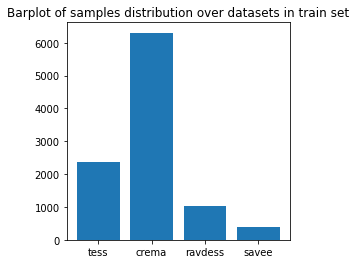

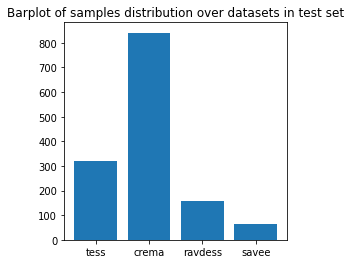

In [ ]:
plot_sample_distribution(original_train_annot, "train")
plot_sample_distribution(test_annot, "test")

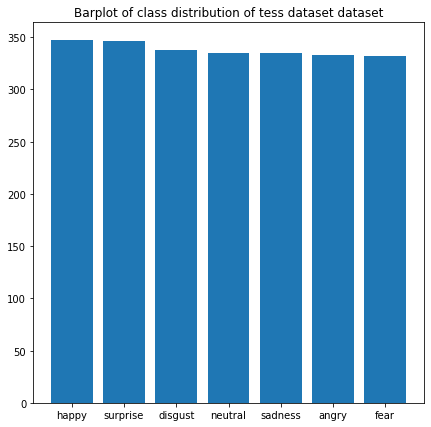

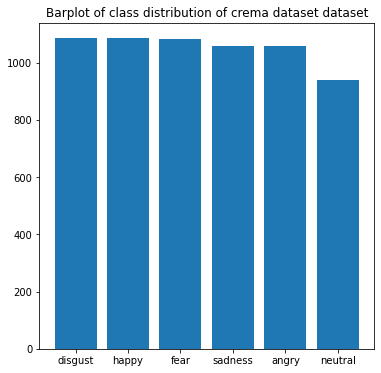

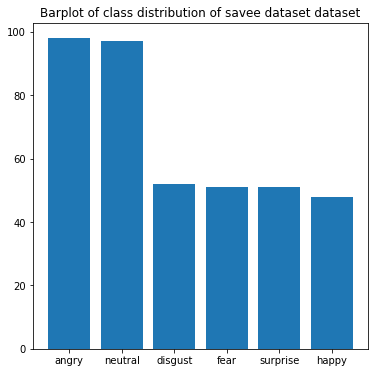

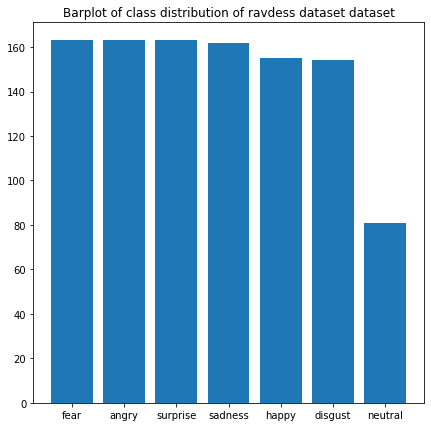

In [ ]:
tess_dataset = original_train_annot.loc[original_train_annot['origin'] == "tess"]
plot_class_distribution(tess_dataset, "tess dataset")
crema_dataset = original_train_annot.loc[original_train_annot['origin'] == "crema"]
plot_class_distribution(crema_dataset, "crema dataset")
savee_dataset = original_train_annot.loc[original_train_annot['origin'] == "savee"]
plot_class_distribution(savee_dataset, "savee dataset")
ravdess_dataset = original_train_annot.loc[original_train_annot['origin'] == "ravdess"]
plot_class_distribution(ravdess_dataset, "ravdess dataset")

In [ ]:
print_average_duration(original_train_annot, "Training")
print_average_duration(test_annot, "test", dir=TEST_DIR)
print_average_duration(tess_dataset, "tess", dir=TRAIN_DIR)
print_average_duration(crema_dataset, "crema", dir=TRAIN_DIR)
print_average_duration(savee_dataset, "savee", dir=TRAIN_DIR)
print_average_duration(ravdess_dataset, "ravdess", dir=TRAIN_DIR)

Training set
Total number of samples: 10111, average duration: 2.59698595028289
Max duration: 7.138730158730159, min_duration = 1.2541043083900227

test set
Total number of samples: 1385, average duration: 2.620570839165998
Max duration: 6.12952380952381, min_duration = 1.3124263038548754

tess set
Total number of samples: 2367, average duration: 2.054052001873837
Max duration: 2.9848072562358277, min_duration = 1.2541043083900227

crema set
Total number of samples: 6306, average duration: 2.541315595484362
Max duration: 5.005034013605442, min_duration = 1.2679818594104308

savee set
Total number of samples: 397, average duration: 3.866647132404596
Max duration: 7.138730158730159, min_duration = 1.6309297052154195

ravdess set
Total number of samples: 1041, average duration: 3.684523341196861
Max duration: 5.2719727891156465, min_duration = 2.9696598639455782


In [ ]:
train_annot = pd.read_csv(TRAINING_FILE, index_col=0)
val_annot = pd.read_csv(VALIDATION_FILE, index_col=0)
test_annot = pd.read_csv(TEST_FILE, index_col=0)

angry       1322
happy       1307
disgust     1303
fear        1302
sadness     1244
neutral     1162
surprise     448
Name: emotion, dtype: int64


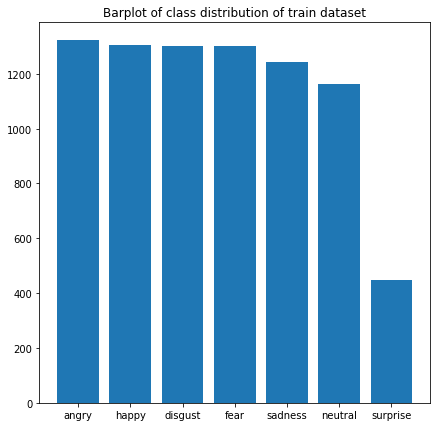

In [ ]:
plot_class_distribution(train_annot, "train")

angry       330
happy       327
disgust     326
fear        326
sadness     311
neutral     290
surprise    112
Name: emotion, dtype: int64


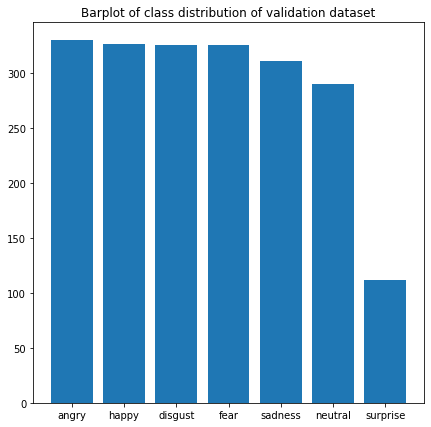

In [ ]:
plot_class_distribution(val_annot, "validation")

In [ ]:
print_average_duration(val_annot)

100%|██████████| 2022/2022 [03:11<00:00, 10.54it/s]


Total number of samples: 2022, average duration: 2.568466617771404
Max duration: 7.138730158730159, min_duration = 1.2880725623582767


In [ ]:
print_average_duration(train_annot)

100%|██████████| 8088/8088 [13:37<00:00,  9.89it/s]


Total number of samples: 8088, average duration: 2.604436874650934
Max duration: 6.289297052154195, min_duration = 1.2541043083900227


In [ ]:
print_average_duration(test_annot, TEST_DIR)

100%|██████████| 1385/1385 [01:59<00:00, 11.59it/s]


Total number of samples: 1385, average duration: 2.620570839165998
Max duration: 6.12952380952381, min_duration = 1.3124263038548754


data 35432
sampling_rate 22050


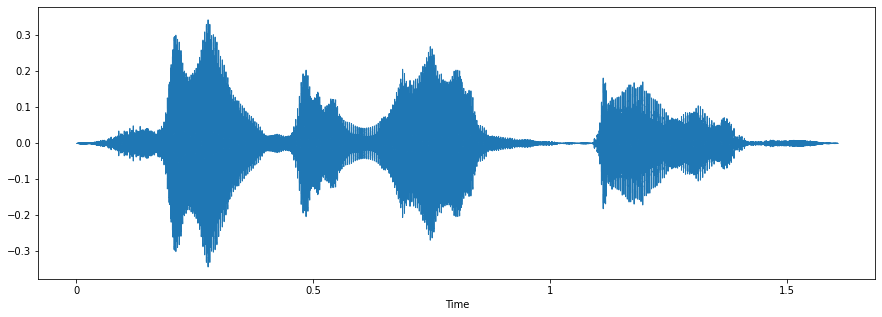

In [ ]:
random_file_id = train_annot.sample()['file_id'].values[0]

fname = TRAIN_DIR + random_file_id

data, sampling_rate = librosa.load(fname)

print("data", len(data))
print("sampling_rate", sampling_rate)

audio_data, _ = librosa.effects.trim(data)

plt.figure(figsize=(15,5))
librosa.display.waveshow(audio_data, sr=sampling_rate)

ipd.Audio(fname)

# Training

## Model Definition

In [ ]:
def get_data_model(model_type, feature_subtype="", reverse=False, scaled=True):
  '''Returns the compiled model and the dataset needed by that model, depending on the input parameters.
    Parameters
    ----------
    model_type: Possibilities are:
                    -  "fused" to get the cnn1D-lstm and cnn2D-lstm fused model.
                    -  "1D" to get the cnn1D-lstm model if reverse is False, otherwise the lstm-cnn1D model.                    
                    -  "2D" to get the cnn2D-lstm model if reverse is False, otherwise the lstm-cnn2D model 

    feature_subtype: is used to specify the type of 1D features, so it is never used when model_type is 2D. Possibilities are "" for all the features, _no_mel" just for chroma and mfcc, "_no_mel_no_chroma" just form mfcc.
    
    reverse: if False returns the model type cnn?D-lstm, otherwise returns the model type lstm-cnn?D.

    scaled: Use a standard scaler to scale the features.

    Return
    ----------
    train_ds: tf.data.Dataset cached and batched containing the training set.
    val_ds: tf.data.Dataset cached and batched containing the validation set.
    model: the compiled model.
  '''
  feature_shape = {"": (180, 1), "_no_mel": (52, 1), "_no_mel_no_chroma": (40, 1), "2D": (128, 251, 1)}
  if model_type == "1D":    
    train_ds = get_dataset("train", "1", feature_subtype, scaled=scaled)
    val_ds = get_dataset("val", "1", feature_subtype, scaled=scaled)
    if reverse:
      model = get_lstm_cnn1D_model(feature_shape[feature_subtype])
    else:  
      model = get_cnn1D_lstm_model(feature_shape[feature_subtype])

  elif model_type == "2D":
    train_ds = get_dataset("train", "2", scaled=scaled)
    val_ds = get_dataset("val", "2", scaled=scaled)
    
    if reverse:
      model = get_lstm_cnn2D_model(feature_shape[feature_subtype])
    else:  
      model = get_cnn2D_lstm_model(feature_shape[model_type])

  elif model_type == "fused":
    train_features_1D, train_features_2D, train_labels = get_dataset_fused_model("train", feature_subtype, scaled=scaled)
    val_features_1D, val_features_2D, val_labels = get_dataset_fused_model("val", feature_subtype, scaled=scaled)
    train_ds = ({"features_1D": train_features_1D, "features_2D": train_features_2D}, train_labels)
    val_ds = ({"features_1D": val_features_1D, "features_2D": val_features_2D}, val_labels)
    if reverse:
      model = get_fused_lstm_cnn_model(feature_shape[feature_subtype], feature_shape[model_type])
    else:
      model = get_fused_cnn_lstm_model(feature_shape[feature_subtype], feature_shape["2D"])
  else:
    print("Type not supported") 

  return train_ds, val_ds, model


def print_results(val_ds, model_to_load, fused=False):
  '''
  Print a classification report with all the interesting metrics obtained using the model and the dataset passed as input.
  Parameters
    ----------
    val_ds: validation dataset on which have to be done the predictions.

    model_to_load: name of the .h5 file that contains a dump of the model to test.

    fused: Boolean to specify if model_to_load is the fused model.    

  ''' 
  model_loaded = tf.keras.models.load_model((model_to_load), custom_objects={"TransformerBlock": TransformerBlock})

  if fused:
    gold_labels = val_ds[1]
    loss, acc = model_loaded.evaluate(val_ds[0], val_ds[1], verbose=0)
    start_time = time.time()
    predictions = model_loaded.predict(val_ds[0])
    inference_time = time.time() - start_time
  else:
    gold_labels = np.concatenate([y for x, y in val_ds], axis=0)
    loss, acc = model_loaded.evaluate(val_ds, verbose=0)
    start_time = time.time()
    predictions = model_loaded.predict(val_ds)
    inference_time = time.time() - start_time

  pred_labels = predictions.argmax(axis=1)

  matrix = confusion_matrix(gold_labels, pred_labels)
  accuracy_summary = matrix.diagonal()/matrix.sum(axis=1)
  accuracy = accuracy_score(gold_labels, pred_labels)

  f1_summary = f1_score(gold_labels, pred_labels, average=None)
  f1_macro = f1_score(gold_labels, pred_labels, average="macro")

  display(pd.DataFrame({'Accuracy': accuracy, 'Loss': loss, 'F1-macro': f1_macro, 'Inference time': inference_time}, index=[0]))

  classes = ['fear', 'angry', 'happy', 'disgust', 'sadness', 'neutral', 'surprise']
  print("\n\n", "F1 on single classes:")
  display(pd.DataFrame(data=[f1_summary], columns=classes))
  print("\n\n", "Accuracy on single classes:")
  display(pd.DataFrame(data=[accuracy_summary], columns=classes))

### CNN-LSTM model

In [ ]:
def get_cnn2D_lstm_model(input_shape, fused=False):
  '''Returns the compiled CNN2D-LSTM model described in the section 4.1.2 of the documentation.'''
  model = keras.Sequential(name='cnn2D_lstm')

  model.add(layers.Conv2D(filters=128,
                          kernel_size=5,
                          strides=1,
                          padding='same',
                          input_shape=input_shape
                          )
            )
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=2, strides=2))

  model.add(layers.Conv2D(filters=256,
                          kernel_size=5,
                          strides=1,
                          padding='same',
                          )
            )
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=4, strides=4))

  model.add(layers.Conv2D(filters=256,
                          kernel_size=5,
                          strides=1,
                          padding='same'
                          )
            )
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=4, strides=4))

  model.add(layers.Reshape((1, -1)))

  model.add(layers.LSTM(48))

  # if fused is true it just returns the model without the last single layer perceptron and without the compilation
  # in fact it is used by the fused version 
  if fused:
    return model

  model.add(layers.Dense(units=NUM_CLASSES, activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
  model.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy']
                )

  return model


def get_cnn1D_lstm_model(input_shape, fused=False):
  '''Returns the compiled CNN1D-LSTM model described in the section 4.1.3 of the documentation.'''   
  model = keras.Sequential(name='cnn1D_lstm')
  model.add(layers.Conv1D(filters=64, 
                          kernel_size=3, 
                          padding="same",
                          input_shape=input_shape
                          )
          )
  model.add(layers.LeakyReLU())
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Conv1D(filters=128, 
                          kernel_size=3, 
                          padding="same",
                          )
          )
  model.add(layers.LeakyReLU())
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Reshape((-1, 1)))

  model.add(layers.LSTM(48))
  model.add(layers.Dropout(0.4))
  
  # if fused is true it just returns the model without the last single layer perceptron and without the compilation
  # in fact it is used by the fused version 
  if fused:
    return model

  model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

  opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

  model.compile(optimizer=opt,
                loss=loss, 
                metrics=['accuracy']
                )

  return model


def get_fused_cnn_lstm_model(input_shape_1, input_shape_2):
  '''Returns the compiled fused CNN1D-2D-LSTM model described in the section 4.1.4 of the documentation.'''
  input_1D = keras.Input(shape=input_shape_1, dtype=tf.float32, name="features_1D")
  input_2D = keras.Input(shape=input_shape_2, dtype=tf.float32, name="features_2D")  

  x_1D = get_cnn1D_lstm_model(input_shape_1, fused=True)(input_1D) 
  x_2D = get_cnn2D_lstm_model(input_shape_2, fused=True)(input_2D)

  concatted = layers.Concatenate()([x_1D, x_2D])
  x = layers.Reshape((1, -1))(concatted)
  x = TransformerBlock(embed_dim=96, num_heads=5, ff_dim=48)(x)
  x = layers.Flatten()(x)

  output = layers.Dense(NUM_CLASSES, activation="softmax", name='classifier')(x)
  
  model = tf.keras.Model([input_1D, input_2D], output)

  opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
  model.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy']
                )

  return model

In [ ]:
#Decide the model type and the feature type you want to train

MODEL_TYPE="fused"                    #Other possibilities are 1D and 2D
FEATURE_SUBTYPE="_no_mel_no_chroma"   #Other possibilities are _no_mel and ""
PATIENCE=30
BATCH_SIZE=32
EPOCHS=200

In [ ]:
train_ds, val_ds, model = get_data_model(MODEL_TYPE, FEATURE_SUBTYPE, scaled=True)
model.summary()

In [ ]:
# set the path where you want to store the model
checkpoint_path = MODEL_DIR + "cnn_lstm_" + MODEL_TYPE + FEATURE_SUBTYPE + ".h5" 

# save the best model found so far during the execution
checkpoint = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_freq='epoch',
                              save_best_only=True
                              )

# use Early stopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE, verbose=1)

if MODEL_TYPE =="fused":
  history = model.fit(train_ds[0],
            train_ds[1],  
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=val_ds, 
            callbacks=[checkpoint, earlystopping],
            verbose=1
        )
else:
  history = model.fit(train_ds,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=val_ds, 
            callbacks=[checkpoint, earlystopping],
            verbose=1
        )

### LSTM-CNN model

In [ ]:
def get_lstm_cnn1D_model(input_shape): 
  '''Returns the compiled LSTM-CNN1D model described in the section 4.2.1 of the documentation.'''  
  model = keras.Sequential(name='lstm_cnn1D')
  model.add(layers.LSTM (52, return_sequences=True, input_shape=input_shape))

  model.add(layers.Conv1D(filters=128,
                          kernel_size=3,
                          strides=1,
                          padding='same',
                          )
            )
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling1D(pool_size=2, strides=2))
  model.add(layers.Dropout(0.2))

  model.add(layers.GlobalMaxPooling1D())

  model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

  opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

  model.compile(optimizer=opt,
                loss=loss, 
                metrics=['accuracy']
                )
  return model


def get_lstm_cnn2D_model(input_shape):
  '''Returns the compiled LSTM-CNN2D model described in the section 4.2.2 of the documentation.'''     
  model = keras.Sequential(name='lstm_cnn2D')
  model.add(layers.Reshape((input_shape[0], input_shape[1])))

  model.add(layers.LSTM(64))

  model.add(layers.Conv1D(filters=128, 
                          kernel_size=3, 
                          padding="same"
                          )
          )
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling1D(pool_size=2, strides=2))

  model.add(layers.Conv1D(filters=256, 
                          kernel_size=3, 
                          padding="same"
                          )
          )
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling1D(pool_size=2, strides=2))

  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

  opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

  model.compile(optimizer=opt,
                loss=loss, 
                metrics=['accuracy']
                )

  return model


def get_fused_lstm_cnn_model(input_shape_1, input_shape_2=(128, 251, 1)):
  '''Returns the compiled fused LSTM-CNN1D-2D which is not reported in the documentation.''' 
  input_1D = keras.Input(shape=input_shape_1, dtype=tf.float32, name="features_1D")
  input_2D = keras.Input(shape=input_shape_2, dtype=tf.float32, name="features_2D")  

  x_1D = get_lstm_cnn1D_model(input_shape_1)(input_1D)  
  x_2D = get_lstm_cnn2D_model(input_shape_2)(input_2D)

  concatted = layers.Concatenate()([x_1D, x_2D])
  
  output = layers.Dense(NUM_CLASSES, activation="softmax", name='classifier')(concatted)
  model = tf.keras.Model([input_1D, input_2D], output)

  opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
  model.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy']
                )

  return model

In [ ]:
#Decide the model type and the feature type you want to train

MODEL_TYPE="fused"                    #Other possibilities are 1D and 2D
FEATURE_SUBTYPE="_no_mel_no_chroma"   #Other possibilities are _no_mel and ""
PATIENCE=30
BATCH_SIZE=32
EPOCHS=200

In [ ]:
train_ds, val_ds, model = get_data_model(MODEL_TYPE, FEATURE_SUBTYPE, reverse=True, scaled=True)
model.summary()

In [ ]:
# set the path where you want to store the model
checkpoint_path = MODEL_DIR + "lstm_cnn" + MODEL_TYPE + FEATURE_SUBTYPE + ".h5" 

# save the best model found so far during the execution
checkpoint = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_freq='epoch',
                              save_best_only=True
                              )

# use Early stopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE, verbose=1)

if MODEL_TYPE =="fused":
  history = model.fit(train_ds[0],
            train_ds[1],  
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=val_ds, 
            callbacks=[checkpoint, earlystopping],
            verbose=1
        )
else:
  history = model.fit(train_ds,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=val_ds, 
            callbacks=[checkpoint, earlystopping],
            verbose=1
        )


# Transformer based

In [ ]:
class TransformerBlock(layers.Layer):
  '''Defines the Transformer block following the same structure described in the paper 'Attention is All you Need'.''' 
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
      super(TransformerBlock, self).__init__()
      self.embed_dim = embed_dim
      self.num_heads = num_heads
      self.ff_dim = ff_dim
      self.rate = rate
      self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
      self.ffn = keras.Sequential(
          [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
      )
      self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
      self.dropout1 = layers.Dropout(rate)
      self.dropout2 = layers.Dropout(rate)

  def call(self, inputs, training):
      attn_output = self.att(inputs, inputs)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(inputs + attn_output)
      ffn_output = self.ffn(out1)
      ffn_output = self.dropout2(ffn_output, training=training)
      return self.layernorm2(out1 + ffn_output)

  def get_config(self):
      config = super().get_config().copy()
      config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
      })
      return config

In [ ]:
def get_cnn2D_transformer_model(input_shape, fused=False, get_before_transformer=False):
  '''Returns the compiled CNN2D-Transformer model described in the section 4.3 of the documentation.''' 
  model = keras.Sequential(name='cnn2D_transformer')

  model.add(layers.Conv2D(filters=32,
                          kernel_size=5,
                          strides=1,
                          padding='same',
                          input_shape=input_shape, 
                          name="conv2D_32"
                          )
            )
  model.add(layers.BatchNormalization(name="Batch_normalization_1"))
  model.add(layers.Activation('elu', name="Elu_activation_1"))
  model.add(layers.MaxPooling2D(pool_size=2, strides=2, name="Max_pooling_1"))

  model.add(layers.Conv2D(filters=64,
                          kernel_size=5,
                          strides=1,
                          padding='same',
                          name="conv2D_64"
                          )
            )
  model.add(layers.BatchNormalization(name="Batch_normalization_2"))
  model.add(layers.Activation('elu', name="Elu_activation_2"))
  model.add(layers.MaxPooling2D(pool_size=2, strides=2, name="Max_pooling_2"))

  model.add(layers.Conv2D(filters=128,
                          kernel_size=5,
                          strides=1,                        
                          padding='same',
                          name="conv2D_128"
                          )
            )
  model.add(layers.BatchNormalization(name="Batch_normalization_3"))
  model.add(layers.Activation('elu', name="Elu_activation_3"))
  model.add(layers.MaxPooling2D(pool_size=2, strides=2, name="Max_pooling_3"))

  model.add(layers.Conv2D(filters=256,
                          kernel_size=5,
                          strides=1,                        
                          padding='same',
                          name="conv2D_256"
                          )
            )
  model.add(layers.BatchNormalization(name="Batch_normalization_4"))
  model.add(layers.Activation('elu', name="Elu_activation_4"))
  model.add(layers.MaxPooling2D(pool_size=2, strides=2, name="Max_pooling_4"))

  model.add(layers.Dropout(0.5))
  model.add(TransformerBlock(embed_dim=256, num_heads=3, ff_dim=64))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.GlobalMaxPooling2D())

  # if fused is true it just returns the model without the last single layer perceptron and without the compilation
  # in fact it is used by the fused version 
  if fused:
    return model

  model.add(layers.Dense(units=NUM_CLASSES, activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
  model.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy']
                )

  return model


def get_cnn1D_transformer_model(fused=False, get_before_transformer=False):   
  '''Returns the compiled CNN1D-Transformer model which is not described the documentation.''' 
  input_1D = keras.Input(shape=(128, 251), dtype=tf.float32, name="features_2D")

  x = TransformerBlock(embed_dim=251, num_heads=4, ff_dim=128) (input_1D)
  x = layers.Dropout(0.3)(x)
  x = TransformerBlock(embed_dim=251, num_heads=4, ff_dim=128) (x)
  x = layers.Dropout(0.3)(x)
  x = TransformerBlock(embed_dim=251, num_heads=4, ff_dim=128) (x)
  x = layers.Dropout(0.3)(x)  
  x = TransformerBlock(embed_dim=251, num_heads=4, ff_dim=128) (x)
  x = layers.Dropout(0.3)(x)  

  x = layers.Flatten()(x)

  output = layers.Dense(NUM_CLASSES, activation="softmax")(x)

  model = tf.keras.Model(input_1D, output)

  opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

  model.compile(optimizer=opt,
                loss=loss, 
                metrics=['accuracy']
                )
  return model


def get_fused_cnn_lstm_transformer_model(input_shape=(128, 251, 1)):
  '''Returns the compiled fused CNN2D-Transformer CNN2D-LSTM model which is not described the documentation.''' 
  input_2D = keras.Input(shape=input_shape, dtype=tf.float32, name="features_2D")

  input_transformer = layers.Reshape((128, 251))(input_2D)  
  x_transformer = TransformerBlock(embed_dim=251, num_heads=3, ff_dim=64) (input_transformer)
  x_transformer = layers.GlobalMaxPooling1D()(x_transformer)  

  x_2D = get_cnn2D_lstm_model(input_shape, fused=True)(input_2D)

  concatted = layers.Concatenate()([x_transformer, x_2D])

  output = layers.Dense(NUM_CLASSES, activation="softmax", name='classifier')(concatted)
  model = tf.keras.Model(input_2D, output)

  opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
  model.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy']
                )

  return model

In [ ]:
#Decide the model type and the feature type you want to train

MODEL_TYPE="2D"                       #Other possibility is 1D
FEATURE_SUBTYPE="_no_mel_no_chroma"   #Other possibilities are _no_mel and ""
PATIENCE=30
BATCH_SIZE=32
EPOCHS=200

In [ ]:
# reuse the function get_data_model to get the training and the validation set
train_ds, val_ds, _ = get_data_model(MODEL_TYPE, FEATURE_SUBTYPE, scaled=True)
model.summary()

In [ ]:
# set the path where you want to store the model
checkpoint_path = MODEL_DIR + "transformer_" + MODEL_TYPE + FEATURE_SUBTYPE + ".h5" 

# save the best model found so far during the execution
checkpoint = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_freq='epoch',
                              save_best_only=True
                              )

# use Early stopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE, verbose=1)

if MODEL_TYPE =="fused":
  history = model.fit(train_ds[0],
            train_ds[1],  
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=val_ds, 
            callbacks=[checkpoint, earlystopping],
            verbose=1
        )
else:
  history = model.fit(train_ds,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=val_ds, 
            callbacks=[checkpoint, earlystopping],
            verbose=1
        )


# Hyperparameters Tuning with Keras Tuner

This section just contain an example of the keras tuner usage, in particular it contains the code to tune the CNN2D-LSTM model.

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 133 kB 5.3 MB/s 


In [ ]:
def model_builder(hp):
  hp_kernel_size = hp.Choice('kernel_size', values=[3, 5])
  hp_first_blocks_filters = hp.Choice('num_filters_first', values=[32, 64, 128])
  hp_second_blocks_filters = hp.Choice('num_filters_second', values=[64, 128, 256])

  model = keras.Sequential(name='model2d_tuner')

  model.add(layers.Conv2D(filters=hp_first_blocks_filters,
                          kernel_size=hp_kernel_size,
                          strides=1,
                          padding='same',
                          input_shape=(128, 251, 1)
                          )
            )
  
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=2, strides=2))

  for i in range(hp.Int('Number of Convolutional Block', 1, 3)):
    model.add(layers.Conv2D(filters=hp_second_blocks_filters,
                          kernel_size=hp_kernel_size,
                          strides=1,
                          padding='same',
                          )
            )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

  model.add(layers.Reshape((1, -1)))

  hp_hidden_LSTM = hp.Int('Hidden units LSTM', 16, 64, step=4)
  model.add(layers.LSTM(hp_hidden_LSTM))
  model.add(layers.Dense(units=NUM_CLASSES, activation='softmax'))


  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
  opt = keras.optimizers.Adam(learning_rate=hp_learning_rate, decay=1e-6)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
  model.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy']
  )

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=70,
                     factor=3,
                     directory=MODEL_DIR,
                     project_name='tuner')

# use earlystopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
tuner.search(train_ds, epochs=70, validation_data=val_ds, callbacks=[earlystopping])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.search_space_summary()

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

base_learning_rate = best_hps.get('learning_rate')

# use earlystopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# save the best model found so far during the execution
tuner_checkpoint = ModelCheckpoint(MODEL_DIR + '/tuner.h5',   # I save in the older Keras H5 format due to a Tensorflow 2.7 bug
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Retrain the model
history_tuner = hypermodel.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[tuner_checkpoint, earlystopping])

In [ ]:
hypermodel.summary()

In [ ]:
plot_metrics(history_tuner)

# Ensemble

In [ ]:
def weighted_average(models_scores, weights):
  weighted_scores = []
  for i in range(len(models_scores[0])):
    weighted_score = [weight*scores[i] for weight, scores in zip(weights, models_scores)]
    weighted_average = np.sum(weighted_score, axis = 0)
    weighted_scores.append(weighted_average)
  return weighted_scores


def show_evaluation(y_pred, y_true, preds):
  print("Classification report: ")
  print(classification_report(y_true, y_pred, digits = 4))
  print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
  print(f'F1 per Class: {f1_score(y_true, y_pred, average=None)}')
  print(f'F1 Macro: {f1_score(y_true, y_pred, average="macro")}')
  print(f'ROC AUC: {roc_auc_score(y_true, preds, average="weighted", multi_class="ovr")}')
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)


In [ ]:
BATCH_SIZE=32
ENSEMBLE_MODELS_PATH = MODEL_DIR + "ensemble_models/"

# define an array with the name of all the models that joins the ensemble 
MODELS_TO_ENSEMBLE = [model_name for model_name in os.listdir(ENSEMBLE_MODELS_PATH) if 'h5' in model_name]
NUM_MODELS = len(MODELS_TO_ENSEMBLE)

# define all the possible dataset that are needed for the ensemble models
MONO_DIM_VAL_DS = get_dataset("val", "1", "_no_mel_no_chroma", scaled=True)
TWO_DIM_VAL_DS = get_dataset("val", "2", scaled=True)

val_features_1D, val_features_2D, VAL_LABELS = get_dataset_fused_model("val", "_no_mel_no_chroma", scaled=True)
FUSED_VAL_DS = {"features_1D": val_features_1D, "features_2D": val_features_2D}

In [ ]:
# Define an array with all the ensemble models loaded from the directory "ensemble_models"
models = []
for i, model_name in enumerate(MODELS_TO_ENSEMBLE):
  model = tf.keras.models.load_model(os.path.join(ENSEMBLE_MODELS_PATH, model_name) , custom_objects={"TransformerBlock": TransformerBlock})
  model._name = f'model_{i}'
  models.append(model)

In [ ]:
# Define a model with the predictions (probability distribution over all the labels) of all the models ensemble 
VAL_SCORES = []
for i, model_name in enumerate(MODELS_TO_ENSEMBLE):
  if '1D' in model_name:
    VAL_SCORES.append(models[i].predict(MONO_DIM_VAL_DS, verbose=1))
  elif 'fused' in model_name :
    VAL_SCORES.append(models[i].predict(FUSED_VAL_DS, verbose=1))
  else:
    VAL_SCORES.append(models[i].predict(TWO_DIM_VAL_DS, verbose=1))

64/64 [==============================] - 4s 51ms/step


In [ ]:
# Define equal weights for all the models to perform an unweighted mean 
weights = [1/NUM_MODELS for _ in range(NUM_MODELS)]

non_weighted_scores = weighted_average(VAL_SCORES, weights)
print(len(non_weighted_scores), non_weighted_scores[0])

In [ ]:
ensemble_predictions = np.argmax(non_weighted_scores, axis=1)
print(ensemble_predictions.shape, ensemble_predictions[:10])

Classification report: 
              precision    recall  f1-score   support

           0     0.7759    0.8182    0.7965       330
           1     0.6744    0.7117    0.6925       326
           2     0.6333    0.6994    0.6647       326
           3     0.7612    0.6728    0.7143       327
           4     0.8078    0.7828    0.7951       290
           5     0.6907    0.6463    0.6678       311
           6     0.9266    0.9018    0.9140       112

    accuracy                         0.7315      2022
   macro avg     0.7529    0.7476    0.7493      2022
weighted avg     0.7340    0.7315    0.7317      2022

Accuracy: 0.7314540059347181
F1 per Class: [0.79646018 0.69253731 0.66472303 0.71428571 0.79509632 0.66777409
 0.91402715]
F1 Macro: 0.7492719706744797
ROC AUC: 0.9479392239118194


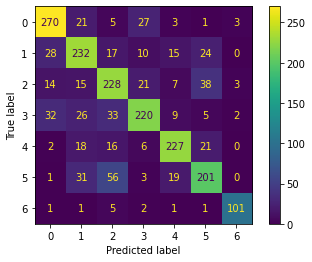

In [ ]:
show_evaluation(ensemble_predictions, VAL_LABELS, non_weighted_scores)

# **Genetic Algorithm**

In [ ]:
# Genetic algorithm parameters
CHROMOSOME_SIZE = NUM_MODELS
CROSSOVER_GENES_PERCENTAGE = 0.5
ELITISM_PERCENTAGE = 0.02

In [ ]:
def initialize_chromosome_population(population_size):
  # Random Initialization
  population = np.random.random((population_size, CHROMOSOME_SIZE))
  ch_sum = np.sum(population, axis=1)
  population = population/ch_sum.reshape((len(ch_sum), 1))
  return population

## **Fitness Functions**

In [ ]:
def f1_macro_measure(weights, y_true, scores):
  weighted_scores = weighted_average(scores, weights)
  y_pred = np.argmax(weighted_scores, axis=1)
  return f1_score(y_true, y_pred, average="macro")


def accuracy_measure(weights, y_true, scores):
  weighted_scores = weighted_average(scores, weights)
  y_pred = np.argmax(weighted_scores, axis=1)
  return accuracy_score(y_true, y_pred)


def roc_auc_measure(weights, y_true, scores):
  weighted_scores = weighted_average(scores, weights)
  return roc_auc_score(y_true, weighted_scores, average="weighted", multi_class="ovr")

In [ ]:
def fitness(chromosome, func='f1'):
  fitness_func = None
  if func == 'auc':
    fitness_func = roc_auc_measure
  elif func == 'f1':
    fitness_func = f1_macro_measure
  elif func == 'acc':
    fitness_func = accuracy_measure
  return fitness_func(chromosome, VAL_LABELS, VAL_SCORES)

## **Selection for Recombination**

In [ ]:
def tournament_selection(population, scores, k=5):
  indexes = np.random.choice(len(population), k, replace=False)
  selected_scores = scores[indexes]
  arg_best = np.argmax(selected_scores)
  return population[indexes[arg_best]]

In [ ]:
def proportional_selection(population, scores):
  scores_sum = np.sum(scores)
  proba = [score/scores_sum for score in scores]
  chosen = np.random.choice(population, 1, p=proba)
  return chosen

In [ ]:
def selection(population, scores, mode='t', k=5):
  individual = None
  if mode == 't':
    individual = tournament_selection(population, scores, k)
  elif mode == 'p':
    individual = proportional_selection(population, scores)
  return individual

## **Crossover**

In [ ]:
def average_crossover(parent_1, parent_2):
  offspring_1, offspring_2 = parent_1.copy(), parent_2.copy()
  num_genes = round(CHROMOSOME_SIZE*CROSSOVER_GENES_PERCENTAGE)
  indexes = np.random.choice(len(parent_1), num_genes, replace=False)
  for i in indexes:
    average = (parent_1[i] + parent_2[i])/2
    offspring_1[i] = average
    offspring_2[i] = average

  offsprings = np.array([offspring_1, offspring_2])
  ch_sum = np.sum(offsprings, axis=1)
  # normalize
  offsprings = offsprings/ch_sum.reshape((len(ch_sum), 1))
  return offsprings

## **Mutation**

In [ ]:
def one_position_mutation(chromosome):
  index = np.random.choice(len(chromosome), 1)
  chromosome[index] = np.random.rand(1)
  return chromosome/np.sum(chromosome)

## **Elitism**

In [ ]:
def get_elite_individulas(population, scores):
  sorted_population = population[np.argsort(scores)[::-1]]
  num_elite = round(len(population)*ELITISM_PERCENTAGE)
  num_elite = 1 if num_elite == 0 else num_elite
  return sorted_population[0:num_elite]

## **GA**

In [ ]:
def genetic_algorithm(num_models, pop_size, num_gen, p_crossover=0.1, p_mutation=0.01, fit_func='f1', sel_mode='t', sel_k=5, init_best_w=None, verbose=1):
  
  # Initialize population
  population = initialize_chromosome_population(pop_size)

  # keep track of best solution
  random_indexes = np.random.choice(pop_size, 1)
  random_individual = population[random_indexes][0]
  if init_best_w is not None:
    population = np.append(population, init_best_w.reshape((1, init_best_w.shape[0])), axis=0)
    best_chromosome, best_fitness = init_best_w, fitness(init_best_w, func=fit_func)
  else:
    best_chromosome, best_fitness = random_individual, fitness(random_individual, func=fit_func)
  print(f'> Initialization: {best_chromosome if verbose == 1 else []} = {best_fitness}')

  for generation in tqdm.tqdm(range(num_gen)):
    # evaluate all candidates in the population
    scores = np.array([fitness(x, func=fit_func) for x in population])

    # check for new best solution
    gen_best_index = np.argmax(scores)
    if scores[gen_best_index] > best_fitness:
      best_chromosome, best_fitness = population[gen_best_index], scores[gen_best_index]
      print(f'> Generation {generation}: new best {best_chromosome if verbose == 1 else []} = {best_fitness}')
    
    # select individuals for recombination
    P1 = np.array([selection(population, scores, mode=sel_mode, k=sel_k) for _ in population])

    # generate mating pool
    MP = np.array([x for x in P1 if np.random.rand(1) < p_crossover])

    # create the next generation
    P3 = []
    for _ in range(0, pop_size, 2):
      # random parent selection
      i1 = np.random.choice(MP.shape[0], 1)
      p1 = MP[i1][0]
      while True:
        i2 = np.random.choice(MP.shape[0], 1)
        if i2 == i1:
          continue
        p2 = MP[i2][0]
        break
      
      # crossover
      offsprings = average_crossover(p1, p2)

      for offspring in offsprings:
        if np.random.rand(1) < p_mutation:
          # mutation
          offspring = one_position_mutation(offspring)

        # store for next generation
        P3.append(offspring)
    P3 = np.array(P3)

    # mantain elite individual
    elite = get_elite_individulas(population, scores)

    # replace population
    population = np.concatenate((P3, elite))
  return [best_chromosome, best_fitness]

In [ ]:
best_fitness = -1
for i in range(10):
  print("Iteration ", i)
  individual, fit = genetic_algorithm(NUM_MODELS, pop_size=100, num_gen=15, p_crossover=0.4, p_mutation=0.005, fit_func='f1')
  if fit > best_fitness:
    best_fitness = fit
    best_weights = individual
  print("------------")

Iteration  0
> Initialization: [0.17581597 0.30268703 0.07697468 0.19823849 0.2283771  0.01790673] = 0.7484140267632612


  7%|▋         | 1/15 [00:05<01:14,  5.34s/it]

> Generation 0: new best [0.20205529 0.14340844 0.09376591 0.10510367 0.21506475 0.24060193] = 0.7561403182682457


 13%|█▎        | 2/15 [00:10<01:09,  5.34s/it]

> Generation 1: new best [0.22989701 0.19427915 0.15994008 0.09454645 0.09749346 0.22384385] = 0.7584407889467396


 27%|██▋       | 4/15 [00:21<00:59,  5.37s/it]

> Generation 3: new best [0.24720266 0.22449637 0.12845223 0.06182269 0.16198802 0.17603803] = 0.7585451351264684


 33%|███▎      | 5/15 [00:26<00:53,  5.36s/it]

> Generation 4: new best [0.23880344 0.25423049 0.11483386 0.03366289 0.15037053 0.20809878] = 0.7600416352408671


 47%|████▋     | 7/15 [00:38<00:44,  5.52s/it]

> Generation 6: new best [0.24176825 0.25682544 0.08003544 0.08104148 0.16302821 0.17730118] = 0.7612598867251367


 53%|█████▎    | 8/15 [00:43<00:38,  5.45s/it]

> Generation 7: new best [0.23932319 0.24672974 0.11698273 0.05003973 0.15308088 0.19384372] = 0.7613559292194029


 60%|██████    | 9/15 [00:48<00:32,  5.42s/it]

> Generation 8: new best [0.23313059 0.24965186 0.10538689 0.0597275  0.15235547 0.19974769] = 0.7613800768653095


 67%|██████▋   | 10/15 [00:54<00:27,  5.43s/it]

> Generation 9: new best [0.23683595 0.24875481 0.11297971 0.05308431 0.14831594 0.20002928] = 0.7618197147015252


 80%|████████  | 12/15 [01:05<00:16,  5.42s/it]

> Generation 11: new best [0.23998651 0.25645737 0.10320337 0.05089443 0.15370517 0.19575315] = 0.7622428112022118


 87%|████████▋ | 13/15 [01:10<00:10,  5.43s/it]

> Generation 12: new best [0.24114675 0.25395623 0.1029954  0.05300886 0.15377996 0.19511279] = 0.7622636274546096


 93%|█████████▎| 14/15 [01:15<00:05,  5.41s/it]

> Generation 13: new best [0.23963585 0.25397989 0.10420035 0.05469338 0.15353207 0.19395847] = 0.7626661441081957


100%|██████████| 15/15 [01:21<00:00,  5.42s/it]


------------
Iteration  1
> Initialization: [0.20229797 0.24941697 0.02263585 0.19631699 0.11489108 0.21444114] = 0.7544803732420411


  7%|▋         | 1/15 [00:06<01:25,  6.13s/it]

> Generation 0: new best [0.16605657 0.21512886 0.03349981 0.14095874 0.24477282 0.1995832 ] = 0.755264449467501


 13%|█▎        | 2/15 [00:11<01:14,  5.69s/it]

> Generation 1: new best [0.09785042 0.25036543 0.14891074 0.16687356 0.127329   0.20867085] = 0.7571135521048796


 20%|██        | 3/15 [00:16<01:06,  5.57s/it]

> Generation 2: new best [0.21409347 0.22857872 0.12066614 0.08713575 0.16619671 0.18332921] = 0.7590819892301355


 27%|██▋       | 4/15 [00:22<01:00,  5.52s/it]

> Generation 3: new best [0.20561015 0.2480251  0.07918003 0.10676294 0.15392784 0.20649394] = 0.7599311257802281


 33%|███▎      | 5/15 [00:27<00:54,  5.48s/it]

> Generation 4: new best [0.1879047  0.25403043 0.13081267 0.07077055 0.15018943 0.20629223] = 0.7613485967777004


 53%|█████▎    | 8/15 [00:43<00:37,  5.41s/it]

> Generation 7: new best [0.20614743 0.2486075  0.09772381 0.10282794 0.15428929 0.19040403] = 0.7621988107347185


 80%|████████  | 12/15 [01:05<00:16,  5.40s/it]

> Generation 11: new best [0.20742003 0.24953646 0.09385409 0.09820119 0.15686586 0.19412237] = 0.7622307423497255


 87%|████████▋ | 13/15 [01:11<00:10,  5.42s/it]

> Generation 12: new best [0.20654727 0.24858538 0.09510968 0.10010717 0.15626799 0.1933825 ] = 0.7626533136677682


100%|██████████| 15/15 [01:21<00:00,  5.46s/it]


------------
Iteration  2
> Initialization: [0.29065974 0.23891992 0.02230319 0.22534139 0.07956116 0.14321459] = 0.7493007497771665


  7%|▋         | 1/15 [00:05<01:15,  5.37s/it]

> Generation 0: new best [0.23090338 0.20424403 0.04848376 0.02810509 0.2264038  0.26185995] = 0.7573563539030271


 13%|█▎        | 2/15 [00:10<01:11,  5.49s/it]

> Generation 1: new best [0.23014585 0.2510075  0.16430526 0.04042254 0.13028902 0.18382983] = 0.7603140468382935


 20%|██        | 3/15 [00:16<01:06,  5.51s/it]

> Generation 2: new best [0.22875706 0.25202619 0.07590304 0.09926662 0.16034109 0.183706  ] = 0.7608563931308858


 27%|██▋       | 4/15 [00:21<01:00,  5.46s/it]

> Generation 3: new best [0.22399299 0.26469033 0.093244   0.0715372  0.15353143 0.19300405] = 0.7618067235392783


 47%|████▋     | 7/15 [00:38<00:45,  5.63s/it]

> Generation 6: new best [0.22349289 0.26213274 0.11229604 0.07084597 0.14009324 0.19113913] = 0.7621520753438163


 60%|██████    | 9/15 [00:49<00:33,  5.55s/it]

> Generation 8: new best [0.22324056 0.26330401 0.11216925 0.06935793 0.13993507 0.19199319] = 0.7625761895596473


100%|██████████| 15/15 [01:21<00:00,  5.46s/it]


------------
Iteration  3
> Initialization: [0.20749843 0.22259049 0.15809309 0.16198518 0.11819343 0.13163938] = 0.7496070674943495


  7%|▋         | 1/15 [00:05<01:12,  5.21s/it]

> Generation 0: new best [0.17429808 0.30674216 0.04987904 0.09720684 0.12566943 0.24620445] = 0.7578427372911561


 13%|█▎        | 2/15 [00:10<01:08,  5.26s/it]

> Generation 1: new best [0.03131795 0.20168141 0.01630482 0.08422636 0.23269787 0.4337716 ] = 0.759899951775365


 27%|██▋       | 4/15 [00:21<00:58,  5.29s/it]

> Generation 3: new best [0.0946558  0.20491257 0.01797818 0.09469809 0.22709998 0.36065538] = 0.7605731720146842


 33%|███▎      | 5/15 [00:26<00:53,  5.34s/it]

> Generation 4: new best [0.06319374 0.20396469 0.01635837 0.08450299 0.23346214 0.39851808] = 0.7613781302060572


 40%|████      | 6/15 [00:31<00:48,  5.35s/it]

> Generation 5: new best [0.09713739 0.19925156 0.01059292 0.08985353 0.23305388 0.37011071] = 0.7614289906178406


 53%|█████▎    | 8/15 [00:42<00:37,  5.34s/it]

> Generation 7: new best [0.08245522 0.20175481 0.010726   0.09298295 0.23732052 0.37476049] = 0.7618720849105378


 60%|██████    | 9/15 [00:47<00:32,  5.35s/it]

> Generation 8: new best [0.08763478 0.20102999 0.01630243 0.08821937 0.23266376 0.37414967] = 0.7618924960597921


 67%|██████▋   | 10/15 [00:53<00:26,  5.36s/it]

> Generation 9: new best [0.07294139 0.19975434 0.01546091 0.09403387 0.23329149 0.38451802] = 0.7619217451446322


100%|██████████| 15/15 [01:20<00:00,  5.38s/it]


------------
Iteration  4
> Initialization: [0.10314947 0.19364807 0.24654231 0.25845388 0.03529356 0.16291271] = 0.7357687461690123


  7%|▋         | 1/15 [00:05<01:16,  5.49s/it]

> Generation 0: new best [0.25737666 0.14074622 0.13165074 0.04259009 0.25442229 0.17321401] = 0.7566650530358924


 13%|█▎        | 2/15 [00:11<01:12,  5.59s/it]

> Generation 1: new best [0.22634214 0.15440342 0.03621065 0.17561592 0.20431505 0.20311283] = 0.7566810439905682


 20%|██        | 3/15 [00:16<01:07,  5.59s/it]

> Generation 2: new best [0.24269204 0.13943157 0.12855558 0.04016011 0.23990622 0.20925448] = 0.7578405174521884


 27%|██▋       | 4/15 [00:22<01:01,  5.56s/it]

> Generation 3: new best [0.23718806 0.16141545 0.0875067  0.12738765 0.21647972 0.17002242] = 0.7593775612367537


 40%|████      | 6/15 [00:33<00:49,  5.48s/it]

> Generation 5: new best [0.23953042 0.15967981 0.03626897 0.14701789 0.22187138 0.19563154] = 0.7594232227628349


 47%|████▋     | 7/15 [00:38<00:43,  5.46s/it]

> Generation 6: new best [0.24491577 0.16233051 0.03813147 0.13687862 0.22154313 0.1962005 ] = 0.7598128960211455


 53%|█████▎    | 8/15 [00:43<00:38,  5.44s/it]

> Generation 7: new best [0.24370958 0.16153105 0.03794368 0.14124917 0.22061536 0.19495115] = 0.759858202037527


100%|██████████| 15/15 [01:21<00:00,  5.44s/it]


------------
Iteration  5
> Initialization: [0.08492853 0.234767   0.33398391 0.0366834  0.02582003 0.28381714] = 0.7470156729833198


  7%|▋         | 1/15 [00:05<01:14,  5.35s/it]

> Generation 0: new best [0.26302138 0.14532369 0.15560707 0.0168055  0.2261135  0.19312887] = 0.7559620970301176


 13%|█▎        | 2/15 [00:10<01:09,  5.37s/it]

> Generation 1: new best [0.20694323 0.25925762 0.14443543 0.07054176 0.12142939 0.19739257] = 0.7598390378964017


 33%|███▎      | 5/15 [00:26<00:53,  5.39s/it]

> Generation 4: new best [0.20806667 0.26066507 0.12799598 0.06814333 0.13666479 0.19846417] = 0.7603337021894007


 40%|████      | 6/15 [00:32<00:48,  5.39s/it]

> Generation 5: new best [0.17686583 0.26632287 0.11360376 0.11103932 0.13340555 0.19876267] = 0.7614908197531857


 47%|████▋     | 7/15 [00:37<00:43,  5.39s/it]

> Generation 6: new best [0.20678329 0.25905726 0.12035134 0.08034218 0.13582182 0.1976441 ] = 0.7616906886423562


 53%|█████▎    | 8/15 [00:43<00:37,  5.40s/it]

> Generation 7: new best [0.1867803  0.26108227 0.12108503 0.10885434 0.12734656 0.19485149] = 0.7619534345344743


 67%|██████▋   | 10/15 [00:53<00:26,  5.39s/it]

> Generation 9: new best [0.19624229 0.25940521 0.11807653 0.0976916  0.13511774 0.19346663] = 0.7620912803036871


 80%|████████  | 12/15 [01:04<00:16,  5.36s/it]

> Generation 11: new best [0.19326879 0.26581716 0.11740188 0.09519182 0.13134834 0.19697201] = 0.7624506326752566


100%|██████████| 15/15 [01:20<00:00,  5.37s/it]


------------
Iteration  6
> Initialization: [0.164529   0.06397559 0.1251564  0.17403186 0.36584179 0.10646536] = 0.7354632865154821


  7%|▋         | 1/15 [00:05<01:14,  5.33s/it]

> Generation 0: new best [0.26526529 0.24072386 0.0665992  0.18485889 0.13019061 0.11236215] = 0.7558848487058574


 13%|█▎        | 2/15 [00:10<01:09,  5.37s/it]

> Generation 1: new best [0.20689029 0.21930617 0.01889096 0.03427193 0.20223766 0.31840299] = 0.7581272792323723


 20%|██        | 3/15 [00:16<01:04,  5.37s/it]

> Generation 2: new best [0.21775011 0.28823557 0.0927095  0.07787667 0.14399368 0.17943447] = 0.7602008919546497


 27%|██▋       | 4/15 [00:21<00:58,  5.30s/it]

> Generation 3: new best [0.23128838 0.2503748  0.09866195 0.08128482 0.15029534 0.18809472] = 0.7617952962295157


 40%|████      | 6/15 [00:31<00:47,  5.32s/it]

> Generation 5: new best [0.23171714 0.25540584 0.09107907 0.08067903 0.15092062 0.19019831] = 0.762194669557165


 53%|█████▎    | 8/15 [00:42<00:37,  5.37s/it]

> Generation 7: new best [0.23122016 0.25485804 0.09465341 0.08050599 0.15004752 0.18871487] = 0.762243265709228


100%|██████████| 15/15 [01:20<00:00,  5.34s/it]


------------
Iteration  7
> Initialization: [0.37884447 0.2109114  0.00717687 0.09209138 0.30780165 0.00317423] = 0.7469936502982464


  7%|▋         | 1/15 [00:05<01:14,  5.31s/it]

> Generation 0: new best [0.24360163 0.17324434 0.06936102 0.13295512 0.22346041 0.15737749] = 0.7559113952342703


 13%|█▎        | 2/15 [00:10<01:09,  5.35s/it]

> Generation 1: new best [0.21132606 0.24030932 0.12730571 0.07555317 0.13472739 0.21077835] = 0.7590544556316592


 20%|██        | 3/15 [00:16<01:04,  5.34s/it]

> Generation 2: new best [0.20784206 0.23634749 0.1252069  0.09866764 0.15120888 0.18072704] = 0.7608622271284992


 33%|███▎      | 5/15 [00:26<00:53,  5.34s/it]

> Generation 4: new best [0.19000527 0.24896937 0.13456191 0.10173187 0.13182287 0.19290872] = 0.7611832258292327


 40%|████      | 6/15 [00:31<00:47,  5.32s/it]

> Generation 5: new best [0.20030118 0.2467183  0.11860942 0.087636   0.14486666 0.20186845] = 0.76131589506787


 53%|█████▎    | 8/15 [00:42<00:37,  5.38s/it]

> Generation 7: new best [0.20072993 0.24657563 0.12391067 0.08213818 0.14272354 0.20392205] = 0.7617405449989249


100%|██████████| 15/15 [01:20<00:00,  5.39s/it]


------------
Iteration  8
> Initialization: [0.08564226 0.1967125  0.20053291 0.20508284 0.02074284 0.29128665] = 0.7395341416677226


  7%|▋         | 1/15 [00:05<01:13,  5.25s/it]

> Generation 0: new best [0.29766539 0.19547718 0.02878143 0.16275606 0.16330685 0.1520131 ] = 0.7552274136525269


 13%|█▎        | 2/15 [00:10<01:09,  5.34s/it]

> Generation 1: new best [0.27800424 0.24107702 0.05846666 0.15328251 0.14821377 0.12095581] = 0.7576351064736897


 20%|██        | 3/15 [00:15<01:03,  5.29s/it]

> Generation 2: new best [0.20854223 0.25562587 0.10871253 0.09197863 0.14264466 0.19249608] = 0.7612177253586455


 33%|███▎      | 5/15 [00:26<00:53,  5.32s/it]

> Generation 4: new best [0.21457514 0.25647183 0.11290218 0.06455355 0.14814202 0.20335527] = 0.7613438630899114


 40%|████      | 6/15 [00:31<00:48,  5.34s/it]

> Generation 5: new best [0.20993868 0.25680563 0.1011188  0.09112228 0.15101072 0.19000389] = 0.7622429627951494


 47%|████▋     | 7/15 [00:37<00:42,  5.34s/it]

> Generation 6: new best [0.20858698 0.24856456 0.10044817 0.10714308 0.15281842 0.1824388 ] = 0.7626344644194506


 53%|█████▎    | 8/15 [00:42<00:37,  5.35s/it]

> Generation 7: new best [0.20989977 0.25675803 0.10102212 0.09110539 0.15139244 0.18982224] = 0.7626902956300956


100%|██████████| 15/15 [01:19<00:00,  5.33s/it]


------------
Iteration  9
> Initialization: [0.22312626 0.22762949 0.08269028 0.18474899 0.16715836 0.11464662] = 0.7523918539310258


  7%|▋         | 1/15 [00:05<01:14,  5.30s/it]

> Generation 0: new best [0.19940723 0.17378751 0.00710049 0.05518258 0.24112006 0.32340213] = 0.7554251792485033


 13%|█▎        | 2/15 [00:10<01:09,  5.32s/it]

> Generation 1: new best [0.176275   0.28428941 0.10217019 0.1114465  0.11667548 0.20914342] = 0.760136303410302


 20%|██        | 3/15 [00:15<01:04,  5.34s/it]

> Generation 2: new best [0.2169944  0.25934984 0.13096791 0.06757138 0.13734154 0.18777494] = 0.7603500002667681


 27%|██▋       | 4/15 [00:21<00:58,  5.33s/it]

> Generation 3: new best [0.2318752  0.26092833 0.10678762 0.06546447 0.14054319 0.19440119] = 0.7608067868860696


 33%|███▎      | 5/15 [00:26<00:53,  5.31s/it]

> Generation 4: new best [0.19628027 0.26543623 0.10720763 0.09909174 0.14288202 0.18910211] = 0.7612543017735536


 40%|████      | 6/15 [00:31<00:48,  5.34s/it]

> Generation 5: new best [0.20759788 0.26220205 0.11720692 0.08430119 0.13885196 0.18984   ] = 0.7625324710016066


 53%|█████▎    | 8/15 [00:42<00:37,  5.31s/it]

> Generation 7: new best [0.2011812  0.27912898 0.12519793 0.07452854 0.1335278  0.18643554] = 0.7629841530238342


100%|██████████| 15/15 [01:19<00:00,  5.33s/it]

------------


In [ ]:
print(best_weights)
print(best_fitness) # the fitness chosen is the F1 macro

[0.2011812  0.27912898 0.12519793 0.07452854 0.1335278  0.18643554]
0.7629841530238342


Classification report: 
              precision    recall  f1-score   support

           0     0.7835    0.8333    0.8076       330
           1     0.6857    0.7362    0.7101       326
           2     0.6384    0.7147    0.6744       326
           3     0.8058    0.6850    0.7405       327
           4     0.8099    0.7931    0.8014       290
           5     0.7113    0.6495    0.6790       311
           6     0.9364    0.9196    0.9279       112

    accuracy                         0.7453      2022
   macro avg     0.7673    0.7616    0.7630      2022
weighted avg     0.7491    0.7453    0.7455      2022

Accuracy: 0.7453016815034619
F1 per Class: [0.80763583 0.71005917 0.67438495 0.74049587 0.80139373 0.6789916
 0.92792793]
F1 Macro: 0.7629841530238342
ROC AUC: 0.9495215875344575


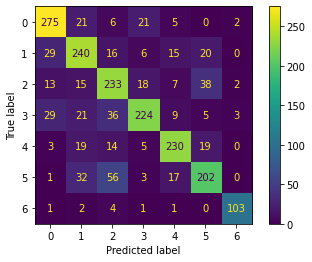

In [ ]:
ensemble_scores = weighted_average(VAL_SCORES, best_weights)
ensemble_predictions = np.argmax(ensemble_scores, axis=1)
show_evaluation(ensemble_predictions, VAL_LABELS, ensemble_scores)

# Ensemble stacking


In [ ]:
def get_cnn2D_lstm_model_stacking():
  '''Returns the compiled CNN2D-LSTM model for binary classification as described in the section 5.2 of the documentation.'''
  model = keras.Sequential(name='cnn2D_lstm')

  model.add(layers.Conv2D(filters=128,
                          kernel_size=5,
                          strides=1,
                          padding='same',
                          input_shape=(128, 251, 1)
                          )
            )
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=2, strides=2))

  model.add(layers.Conv2D(filters=128,
                          kernel_size=5,
                          strides=1,
                          padding='same',
                          )
            )
  
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=4, strides=4))

  model.add(layers.Conv2D(filters=256,
                          kernel_size=5,
                          strides=1,
                          padding='same'
                          )
            )
  
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('elu'))
  model.add(layers.MaxPooling2D(pool_size=4, strides=4))

  model.add(layers.Reshape((1, -1)))
  model.add(layers.LSTM(48))
  model.add(layers.Dense(units=1, activation='sigmoid'))

  opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) 
  model.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy']
                )

  return model


def get_stacking_model():
  '''Returns the stacking ensemble as described in the section 5.2 of the documentation.'''
  models = []
  input = keras.Input(shape=(128, 251, 1), dtype=tf.float32, name="features")  
  for i in range(NUM_CLASSES):
    model_to_load = MODEL_DIR + "stacking/stacking_" + str(i) + ".h5"
    model_loaded = tf.keras.models.load_model((model_to_load))

    #change the models'name to avoid error for name conflicts 
    model_loaded._name = model_loaded.name + "_" + str(i)
    for layer in model_loaded.layers:
      layer._name = layer.name + "_" + str(i)

    model_loaded.trainable = False
    models.append(model_loaded)

  x = []
  for model in models:
    x.append(model(input))

  concatted = layers.Concatenate()(x)
  
  x = layers.Dense(512, activation="relu")(concatted)
  x = layers.Dropout(0.4)(x)
  output = layers.Dense(NUM_CLASSES, activation="softmax", name='classifier')(x)
  
  model = tf.keras.Model(input, output)

  opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
  model.compile(optimizer=opt,
                loss=loss,
                metrics=['accuracy']
                )

  return model


def map_label(label, current_category):
  if label == current_category:
    return 1
  else:
    return 0

## Training of the seven binary models

In [ ]:
CURRENT_LABEL=6  # set the current label to consider

PATIENCE=15
BATCH_SIZE=32
EPOCHS=50

In [ ]:
# use the function get_data_model to get the training and the validation set
train_ds = get_dataset("train", "2", scaled=True)
val_ds = get_dataset("val", "2", scaled=True)

model = get_cnn2D_lstm_model_stacking()

# change the label of the dataset, casting the multi-class classification problem to a binary classification one 
train_ds = train_ds.map(
    lambda x, y: (x, map_label(y, CURRENT_LABEL)),  # cast the label to transform the problem from multi-class to binary
    num_parallel_calls=tf.data.AUTOTUNE,  # load in parallel
    deterministic=True  # keep the order, we will shuffle after
  ).batch(BATCH_SIZE)  

val_ds = val_ds.map(
    lambda x, y: (x, map_label(y, CURRENT_LABEL)),  # cast the label to transform the problem from multi-class to binary
    num_parallel_calls=tf.data.AUTOTUNE,  # load in parallel
    deterministic=True  # keep the order, we will shuffle after
  ).batch(BATCH_SIZE)    

In [ ]:
# compute the class weights based on the samples distribution in order to give more importance to the minority class
gold_labels = np.concatenate([y for x, y in train_ds], axis=0)

weights = compute_class_weight(class_weight = "balanced",
                                                  classes = np.unique(gold_labels),
                                                  y = gold_labels  )

weights_dict = {i : weights[i] for i in range(len(weights))}
print(weights_dict)

In [ ]:
# set the path where you want to save the model
checkpoint_path = MODEL_DIR + "stacking_" + CURRENT_LABEL + ".h5" 

# save the best model found so far during the execution
checkpoint = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_freq='epoch',
                              save_best_only=True
                              )

# use Early stopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE, verbose=1)

history = model.fit(train_ds,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          validation_data=val_ds, 
          callbacks=[checkpoint, earlystopping],
          class_weight=weights_dict,     # assign class weights depending on the weigths computed
          verbose=1
)

## Training of the complete model (the meta-classifier)

In [ ]:
# set training hyperparameters
PATIENCE=15
BATCH_SIZE=32
EPOCHS=20

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 128, 251, 1  0           []                               
                                )]                                                                
                                                                                                  
 cnn2D_lstm_0 (Sequential)      (None, 1)            2620273     ['features[0][0]']               
                                                                                                  
 cnn2D_lstm_1 (Sequential)      (None, 1)            2620273     ['features[0][0]']               
                                                                                                  
 cnn2D_lstm_2 (Sequential)      (None, 1)            2620273     ['features[0][0]']           

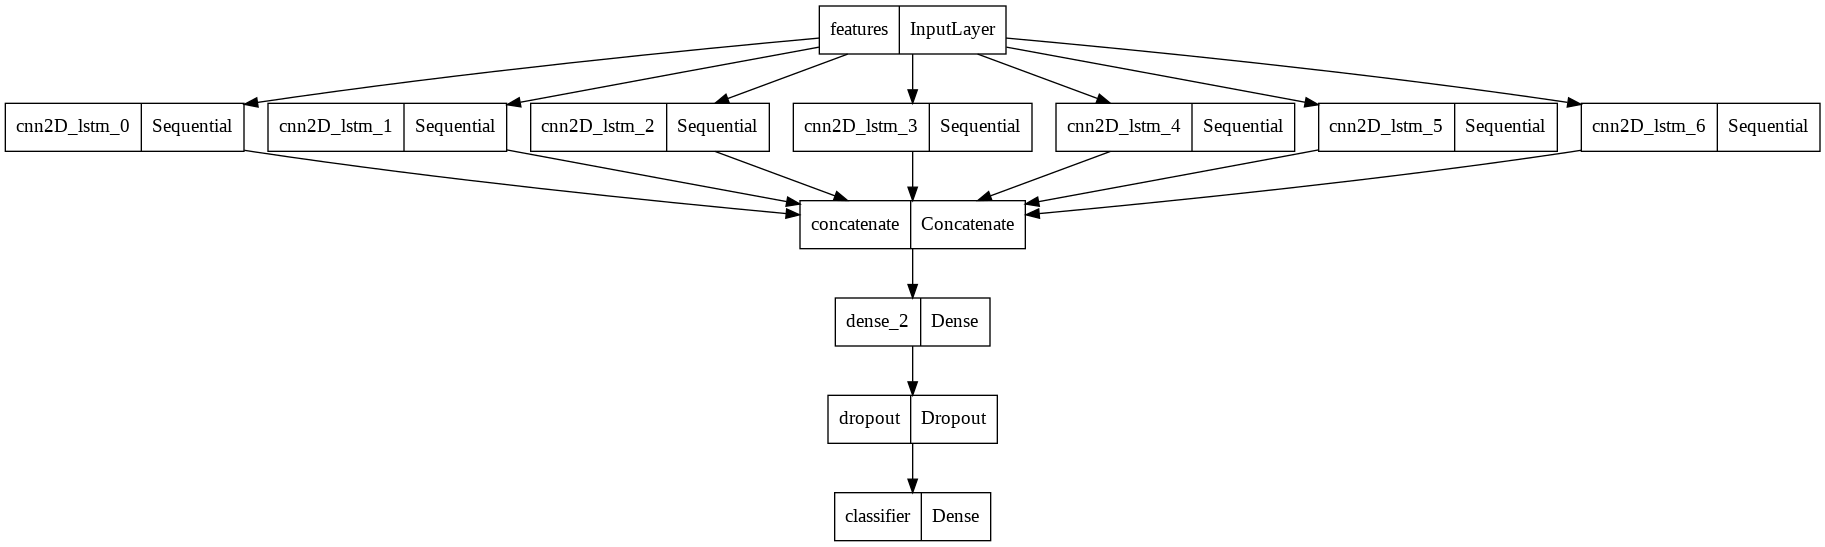

In [ ]:
train_ds = get_dataset("train", "2", scaled=True)
val_ds = get_dataset("val", "2", scaled=True)

model = get_stacking_model()
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
# set the path where you want to save the model
checkpoint_path = MODEL_DIR + "stacking_ensemble.h5" 

# save the best model found so far during the execution
checkpoint = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_freq='epoch',
                              save_best_only=True
                              )

# use Early stopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE, verbose=1)

history = model.fit(train_ds,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          validation_data=val_ds, 
          callbacks=[checkpoint, earlystopping],
          class_weight=weights_dict, 
          verbose=1
)

# Analyze results

In [ ]:
def get_dict_accuracy(elements, correct_dict, error_dict):
  dict_accuracy = {}
  for elem in elements:
    dict_accuracy[elem] = correct_dict[elem]/(error_dict[elem] + correct_dict[elem])

  return dict_accuracy

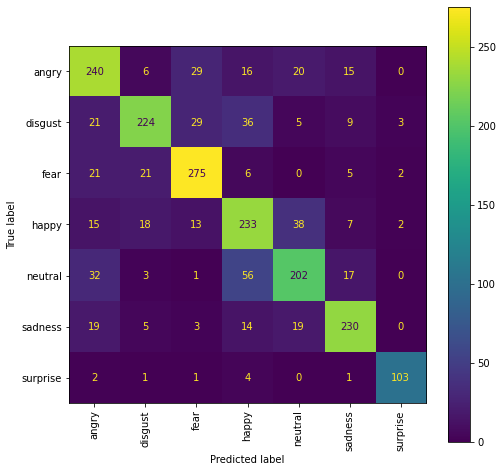

In [ ]:
# I show just the analysis on the ensemble predictions
pred_labels = ensemble_predictions

# get val labels
_, _, val_labels = get_dataset_fused_model("val", "_no_mel_no_chroma", scaled=True)

# define array with true and pred labels
gold = [id2label[str(id)] for id in val_labels]
pred = [id2label[str(id)] for id in pred_labels]

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(gold, pred, xticks_rotation='vertical', ax=ax)

In [ ]:
# define two dictionaries to count the error and the correct classification for each class
error_class_counter = {name:0 for name in CLASS_NAMES}
correct_class_counter = {name:0 for name in CLASS_NAMES}

datasets = list(val_annot.origin.unique())

# define two dictionaries to count the error and the correct classification for each origin
error_dataset_counter = {name:0 for name in datasets}
correct_dataset_counter = {name:0 for name in datasets}

dataset_list = val_annot['origin'].to_list()

In [ ]:
# count the error and the correct classification for each class and each origin
for i in range(len(val_labels)):
  sentiment = id2label[str(val_labels[i])]
  dataset = dataset_list[i]

  if val_labels[i] != pred_labels[i]:
    error_class_counter[sentiment] += 1
    error_dataset_counter[dataset] += 1
  else:
    correct_class_counter[sentiment] +=1
    correct_dataset_counter[dataset] += 1

print("Misclassification on single classes:", error_class_counter)
print("Correct classification on single classes:", correct_class_counter)
print("Misclassification on single dataset:", error_dataset_counter)
print("Correct classification on single dataset:", correct_dataset_counter)

Misclassification on single classes: {'fear': 55, 'angry': 86, 'happy': 93, 'disgust': 103, 'sadness': 60, 'neutral': 109, 'surprise': 9}
Correct classification on single classes: {'fear': 275, 'angry': 240, 'happy': 233, 'disgust': 224, 'sadness': 230, 'neutral': 202, 'surprise': 103}
Misclassification on single dataset: {'crema': 443, 'tess': 0, 'ravdess': 49, 'savee': 23}
Correct classification on single dataset: {'crema': 802, 'tess': 502, 'ravdess': 152, 'savee': 51}


In [ ]:
# print the results obtained

dict_accuracy_dataset = get_dict_accuracy(dataset_list, correct_dataset_counter, error_dataset_counter) 
print("Accuracy on single datasets: ", dict_accuracy_dataset, "\n\n")

dict_accuracy_class = get_dict_accuracy(CLASS_NAMES, correct_class_counter, error_class_counter) 
print("Accuracy on single class: ", dict_accuracy_class)

print("\n\t\t\t  F1 on single class: ")
classes = ['fear', 'angry', 'happy', 'disgust', 'sadness', 'neutral', 'surprise']
f1_summary = f1_score(val_labels, pred_labels, average=None)
pd.DataFrame(data=[f1_summary], columns=classes)

Accuracy on single datasets:  {'crema': 0.6441767068273092, 'tess': 1.0, 'ravdess': 0.7562189054726368, 'savee': 0.6891891891891891} 


Accuracy on single class:  {'fear': 0.8333333333333334, 'angry': 0.7361963190184049, 'happy': 0.7147239263803681, 'disgust': 0.6850152905198776, 'sadness': 0.7931034482758621, 'neutral': 0.6495176848874598, 'surprise': 0.9196428571428571}

			  F1 on single class: 


,fear,angry,happy,disgust,sadness,neutral,surprise
0,0.807636,0.710059,0.674385,0.740496,0.801394,0.678992,0.927928


# Understanding what the network receives as inputs

In [ ]:
fnames = {'angry': "d1b571e9-5221-49b0-9407-b72925981ff0.wav",
         'disgust': "e6f69ec6-77b8-4978-9ed8-c79a1a882164.wav",
         'fear': "e02d62ef-bc4d-4f53-99de-e48230a6bda1.wav",
         'happy': "7b28e820-d850-4b77-841a-de4e9ecf4e35.wav",
         'neutral': "2f32e50b-ee58-4e95-b81f-eb1b1d69e3bd.wav",
         'sadness': "6237aea6-1ddd-4328-a5b7-52e371eb5e12.wav",
         'surprise': "289c547f-3bb6-4438-b2bb-1cda6cef23b7.wav"
         }

fnames_2 = {'angry': "c0ee9531-30f3-439e-8f0e-3e291d95dc61.wav",
         'disgust': "4ceb166c-82e0-49b5-8364-57ea05ff8e9c.wav",
         'fear': "54553fee-8183-4b42-a216-ef3f74e5e024.wav",
         'happy': "2df3dff7-54e6-4518-94af-c939aade10d1.wav",
         'neutral': "7af84260-2241-4032-be1f-b4ccad98c5e3.wav", 
         'sadness': "06765925-a98b-4449-a5a4-ffaf9098d277.wav",
         'surprise': "8ea515e0-9072-4978-9866-791cc14399aa.wav"
         }



In [ ]:
for i, k in fnames.items():
  print(i, k)

angry d1b571e9-5221-49b0-9407-b72925981ff0.wav
disgust e6f69ec6-77b8-4978-9ed8-c79a1a882164.wav
fear e02d62ef-bc4d-4f53-99de-e48230a6bda1.wav
happy 7b28e820-d850-4b77-841a-de4e9ecf4e35.wav
neutral 2f32e50b-ee58-4e95-b81f-eb1b1d69e3bd.wav
sadness 6237aea6-1ddd-4328-a5b7-52e371eb5e12.wav
surprise 289c547f-3bb6-4438-b2bb-1cda6cef23b7.wav


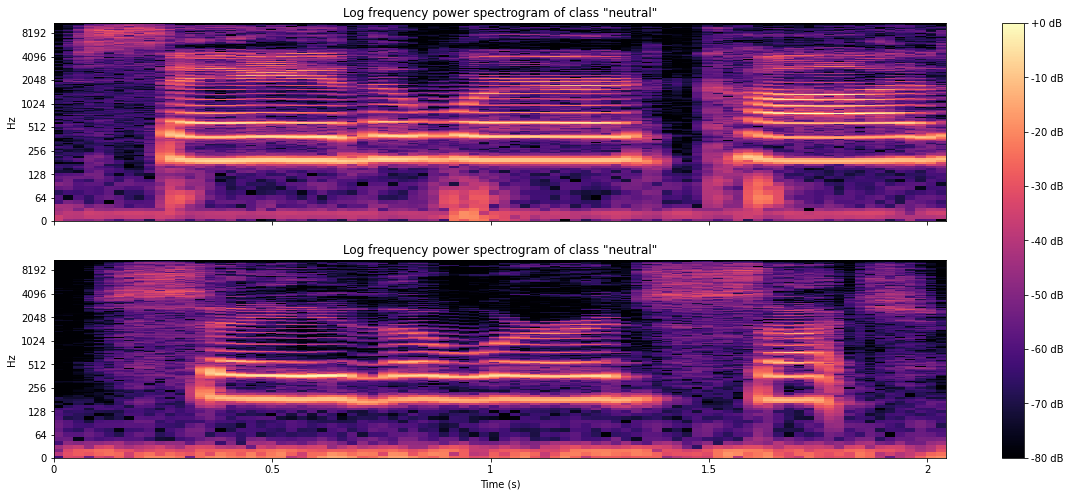

In [ ]:
import librosa.display as dsp

fig,ax = plt.subplots(2,1,sharex=True,figsize=(20,8))
i = 0
for class_ in CLASS_NAMES[4:5]:

  data, sample_rate = librosa.load(TRAIN_DIR + fnames[class_])
  d = librosa.stft(data)
  D = librosa.amplitude_to_db(np.abs(d),ref=np.max)

  img = dsp.specshow(D,y_axis='log',x_axis='s',sr=sample_rate,ax=ax[i])
  ax[i].set(title='Log frequency power spectrogram of class "' + class_ + '"')
  ax[i].label_outer()

  data, sample_rate = librosa.load(TRAIN_DIR + fnames_2[class_])
  d = librosa.stft(data)
  D = librosa.amplitude_to_db(np.abs(d),ref=np.max)

  img = dsp.specshow(D,y_axis='log',x_axis='s',sr=sample_rate,ax=ax[i+1])
  ax[i+1].set(title='Log frequency power spectrogram of class "' + class_ + '"')
  ax[i+1].label_outer()

  i += 2

fig.colorbar(img, ax=ax, format='%+2.f dB')

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


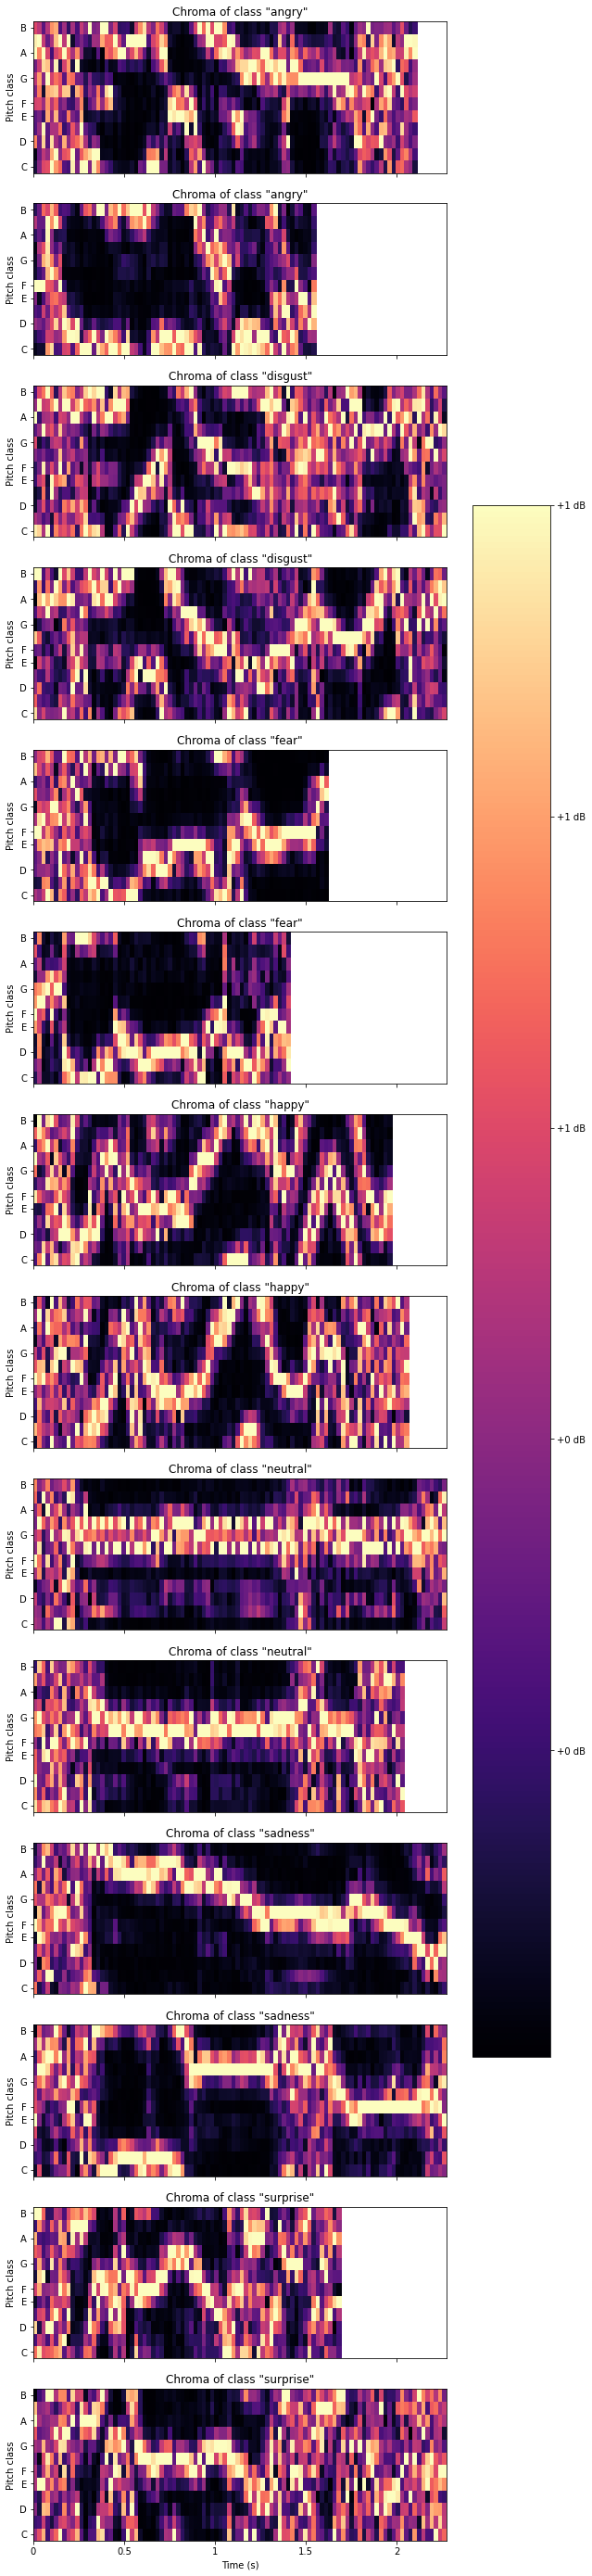

In [ ]:
fig,ax = plt.subplots(14,1,sharex=True,figsize=(10,50))
i = 0
for class_ in CLASS_NAMES:

  data, sample_rate = librosa.load(TRAIN_DIR + fnames[class_])
  d = librosa.stft(data)
  D = librosa.feature.chroma_stft(S=d, sr=sample_rate)

  img = dsp.specshow(D,y_axis='chroma',x_axis='s',sr=sample_rate,ax=ax[i])
  ax[i].set(title='Chroma of class "' + class_ + '"')
  ax[i].label_outer()

  data, sample_rate = librosa.load(TRAIN_DIR + fnames_2[class_])
  d = librosa.stft(data)
  D = librosa.feature.chroma_stft(S=d, sr=sample_rate)

  img = dsp.specshow(D,y_axis='chroma',x_axis='s',sr=sample_rate,ax=ax[i+1])
  ax[i+1].set(title='Chroma of class "' + class_ + '"')
  ax[i+1].label_outer()

  i += 2

fig.colorbar(img, ax=ax, format='%+2.f dB')